### Log-Linear Language Model from Scratch
Exercise 4-6 from Neural Machine Translation and Sequence-to-sequence Models: A Tutorial by 
Graham Neubig (https://arxiv.org/abs/1703.01619)

In [2]:
# imports
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

# maximum n-gram length
n = 2

# load data
X_train = open("en-de/train.en-de.low.filt.en", "r", encoding="UTF-8").readlines()
X_test = open("en-de/test.en-de.low.en", "r", encoding="UTF-8").readlines()

In [3]:
# encode vocab as numerical index
padded_train = []
# automatically register new words to new consequitive ids
w2i = defaultdict(lambda: len(w2i))
# define special characters
S = w2i["<s>"]
END = w2i["</s>"]
UNK = w2i["<UNK>"]

# pad, split, and encode training data (taking subset to avoid dimensionality explosion)
for sentence in X_train[:1000]:
    padded_train.append([S]*n)
    for word in sentence.strip().split():
        padded_train[-1].append(w2i[word])
    padded_train[-1].append(END)

VOCAB = list(w2i.keys())
i2w = {v: k for k,v in w2i.items()}

# vocab length
V = len(VOCAB)
# size of embedding vector, depends on feature function defined below
N = n*V

In [4]:
padded_test = []

# encode uknown words as UNK token
w2i.default_factory = lambda: UNK

# pad, split, and encode test data
for sentence in X_test:
        padded_test.append([S]*n + [w2i[word] for word in sentence.strip().split()] + [END])

In [5]:
# softmax function
def softmax(scores):
    exp = np.exp(scores)
    return exp/np.sum(exp)

# log-likelihood loss
def LL_loss(prob):
    loss = -np.log(prob)
    return loss

# convert indices into one-hot encoding matrix, given vocab size
def onehot(indices, size):
    indices = np.array(indices)
    # creates n x V zeros matrix
    oh_array = np.zeros((size,indices.size))
    # set entries of indices to 1
    oh_array[indices,np.arange(indices.size)] = 1
    # return one-hot array
    return oh_array

# feature function to turn input into feature vector
# concatenated OHE for words in the window, N \in R^{n*V X 1}
def feat_func(window):
    oh_mat = onehot(window, V)
    concatenated = oh_mat.T[::-1].reshape(-1,1)
    return concatenated

# forward pass, compute scores from input given parameters
def forward(x, W, b):
    # affine transformation
    # scores = W @ x + b.reshape(-1,1)

    # lookup, more computationally efficient for sparse matrices (such as one-hot)
    # W[:,j]            \in R^{V X 1}
    # x[j]              \in R^{1}
    # b                 \in R^{V X 1}
    # s                 \in R^{V X 1} = \sum W[:,j] * x[j] + b
    score = np.sum([W[:,j] * x[j] + b for j in range(N) if x[j] != 0],0)
    return score

# optimization step
def step(sentence, W, b, eta = 0.1):
    # convert input to feature vector
    x = feat_func(sentence[:-1])
    # compute probabilities from feature vector and parameters
    probs = softmax(forward(x, W, b))
    # compute the gradients for biases and weights and take optimization step
    dldb = probs.T - onehot(sentence[-1], V).flatten()
    b_step = np.multiply(dldb,eta)
    b -= b_step
    # lookup active weight rows to update
    for j in range(N):
        if np.sum(x[j]) != 0:
            W[:,j] -= b_step*x[j]
    return W, b

def train(X):
    # initialize parameters
    W = np.random.rand(V,N)
    b = np.random.rand(V)
    # for each word in test_data (except padding)
    for sentence in tqdm(X):
        for i in range(n+1, len(sentence)+1):
            # compute step and update parameters
            W, b = step(sentence[i-n-1:i], W, b)
    # in case of unknown word, assume uniform distribution over 1e6 words
    for i in range(UNK,N+UNK,V):
        W[:,i] = np.array([1e-6]*V)
    # return parameters
    return (W, b)

In [6]:
# Train model   
W, b = train(padded_train)

100%|██████████| 1000/1000 [07:00<00:00,  2.38it/s]


100%|██████████| 1565/1565 [02:42<00:00,  9.60it/s]


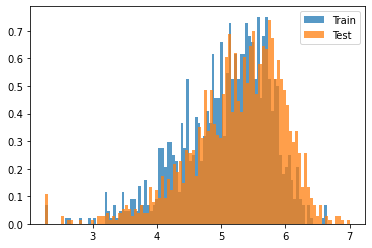

In [7]:
# score model on train and test sets
train_losses = []
test_losses = []

# for each word in each sentence
for sentence in tqdm(padded_train):
    sentence_loss = 0
    for i in range(n+1,len(sentence)):
            # compute probability of word according to model
            x = feat_func(sentence[i-n-1:i-1])
            sentence_loss += LL_loss(softmax(forward(x, W, b))[sentence[i]])
    # normalize by length of sentence
    train_losses.append(sentence_loss/len(sentence))

# as above
for sentence in tqdm(padded_test):
    sentence_loss = 0
    for i in range(n+1,len(sentence)):
            x = feat_func(sentence[i-n-1:i-1])
            sentence_loss += LL_loss(softmax(forward(x, W, b))[sentence[i]])
    test_losses.append(sentence_loss/len(sentence))

# plot losses as histograms
_ = plt.hist(train_losses,100,density=True,alpha=0.75,label="Train")
_ = plt.hist(test_losses,100,density=True,alpha=0.75,label="Test")
plt.legend()
plt.show()

In [8]:
# define prediction functions

def greedy_search_step(past, W, b):
    # compute score vector and choose highest score
    x = feat_func(past[-n:])
    scores = forward(x, W, b)
    # prevent choosing padding token
    scores[0] = 0
    return np.argmax(scores)

def random_search_step(past, W, b):
    # compute score vector and sample from softmaxed distribution
    x = feat_func(past[-n:])
    scores = forward(x, W, b)
    # prevent choosing padding token
    scores[0] = 0
    probs = softmax(scores)
    return np.random.choice(range(V), p = probs)

# predict sentence given seed and length
def search(W, b, seed, length, strat="greedy"):
    sentence = [w2i[word] for word in seed.split()]
    for _ in range(length):
        # halt if end sentence token is reached
        if sentence[-1] == END:
            return " ".join([i2w[i] for i in sentence])
        # predict next word
        if strat == "greedy":
            prediction = greedy_search_step(sentence, W, b)
        if strat == "random":
            prediction = random_search_step(sentence, W, b)
        # append to sentence
        sentence.append(prediction)
    return " ".join([i2w[i] for i in sentence])

In [11]:
# test generation

seed = "the little man had"
length = 10
print(search(W, b, seed, length, "greedy"))
print(search(W, b, seed, length, "random"))

the little man had . </s>
the little man had snap forces problems exchanged it so . </s>


In [17]:
seed = "the little woman had"
length = 10
print(search(W, b, seed, length, "greedy"))
print(search(W, b, seed, length, "random"))

the little woman had , and the in the , and the in the
the little woman had of the are pool are london shredded the it about


fin.